# Udacity PyTorch Challenge Classification Project

In this project an image classifier is trained to recognize different species of flowers using [the Oxford dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, for example:

<img src="https://github.com/AlisonDavey/Machine_and_Deep_Learning_Notebooks/blob/master/image_05459.jpg?raw=true" width=250px>


The project is broken down into:

* Create a test dataset
* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

[PEP 8 -- Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/) says that imports are always put at the top of the file.

Source files https://github.com/udacity/pytorch_challenge


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms, models

import scipy.io as sio
from pathlib import Path
from shutil import copy
import time
#import copy
import shutil
import os
import random

## Data Downloading and Creation of a Test Dataset

Create a test folder (with its labels) for the Udacity PyTorch Challenge flower dataset that contains the images in the original Oxford dataset that are not in the Udacity dataset.

The dataset will then have three parts: training, validation and test. 

In [14]:
# Download the original dataset of 102 different categories of flowers common to the UK 
# from the Visual Geometry Group, Department of Engineering Science, University of Oxford 
# http://www.robots.ox.ac.uk/~vgg/data/flowers/
!wget  -O ./assets/102flowers.tgz "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"


--2019-01-19 17:06:09--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘./assets/102flowers.tgz’

./assets/102flowers 100%[===================>] 328.89M  21.7MB/s    in 16s     

2019-01-19 17:06:27 (20.4 MB/s) - ‘./assets/102flowers.tgz’ saved [344862509/344862509]



In [15]:
# Untar the Oxford dataset
!tar xzf ./assets/102flowers.tgz -C ./assets/


In [16]:
## Download the Oxford labels
!wget  -O ./assets/imagelabels.mat "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"


--2019-01-19 17:07:20--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘./assets/imagelabels.mat’

./assets/imagelabel 100%[===================>]     502  --.-KB/s    in 0s      

2019-01-19 17:07:20 (102 MB/s) - ‘./assets/imagelabels.mat’ saved [502/502]



In [2]:
# Download the Udacity PyTorch Challenge flower dataset 
!wget  -O ./assets/flower_data.zip  "https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip"


In [3]:
# Unzip the Udacity dataset
!unzip ./assets/flower_data.zip -d ./assets/


In [22]:
root_dir = Path('./assets')
original_dir = root_dir/'jpg'
labels_file = root_dir/'imagelabels.mat'
udacity_dir = root_dir/'flower_data'
udacity_train_dir = udacity_dir/'train'
udacity_valid_dir = udacity_dir/'valid'
udacity_test_dir = udacity_dir/'test'

In [29]:
# Script prepared by a student in the Udacity PyTorch Scholarship Challenge, apologies that 
# I didn't note their name
labels=sio.loadmat(labels_file)['labels'][0]
(_, _, original_images) = next(os.walk(original_dir))
original_images = sorted(original_images)
image_to_label = {name: labels[i] for i, name in enumerate(original_images)}
udacity_images = []
for root, dirs, files in os.walk(udacity_dir): udacity_images.extend(files)
diff = set(original_images) - set(udacity_images)
udacity_test_dir.mkdir(parents=True, exist_ok=True)
for file in diff:
    dest_dir = udacity_test_dir/str(image_to_label[file])
    dest_dir.mkdir(parents=True, exist_ok=True)
    copy(original_dir/file, dest_dir)

## Data Loading and Exploration

For the training, transformations such as random scaling, cropping, and flipping are applied. This helps the network generalize leading to better performance. Input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this scaling or rotation transformations are not used, but the images are resized then cropped to the appropriate size.

The test set was created by a student in the challenge by comparing the data selected by Udacity to the original data.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each colour channel was normalized separately. The image data here needs to be normalized using the same means and standard deviations: `[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]`, as those calculated from the ImageNet images.  These values will shift each colour channel to be centered at 0 and range from -1 to 1.

In [2]:
#Load and preprocess the image dataset
data_dir = './assets/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

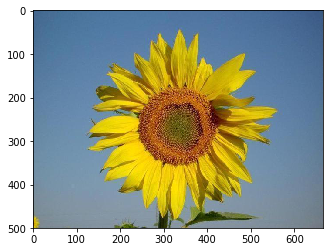

In [27]:
image = Image.open(train_dir+'/54/image_05459.jpg')
plt.imshow(image);

In [30]:
#Exploratory Data Analysis
def eda_counts():
    dirs = [train_dir,valid_dir,test_dir]
    for directory in dirs:
        counts = []
        total_images = 0
        min_count = 100
        max_count = 0
        print ('Dataset: ',directory)
        folders = ([name for name in os.listdir(directory)])
        for folder in folders:
            contents = os.listdir(os.path.join(directory,folder))
            total_images += len(contents)
            if len(contents)<min_count:
                min_count = len(contents)
            if len(contents)>max_count:
                max_count = len(contents)
            counts.append((folder,len(contents)))
        print ('Classes: ', len(counts), 'Fewest: ', min_count, 'Most: ', max_count)
        print ('Number of images: ', total_images)
        print ('Counts per class: ', counts)
        print ()
eda_counts()

Dataset:  ./assets/flower_data/train
Classes:  102 Fewest:  27 Most:  206
Number of images:  6552
Counts per class:  [('87', 51), ('99', 50), ('71', 64), ('60', 85), ('27', 36), ('85', 48), ('100', 35), ('53', 70), ('24', 35), ('48', 57), ('96', 72), ('81', 135), ('13', 38), ('62', 48), ('40', 54), ('64', 42), ('49', 38), ('47', 61), ('32', 36), ('89', 153), ('8', 70), ('44', 73), ('10', 38), ('11', 68), ('98', 68), ('46', 157), ('42', 49), ('61', 36), ('20', 46), ('73', 147), ('56', 92), ('25', 34), ('30', 61), ('22', 47), ('43', 100), ('84', 66), ('18', 65), ('70', 51), ('15', 38), ('69', 46), ('37', 92), ('16', 36), ('33', 31), ('57', 50), ('78', 112), ('101', 49), ('67', 36), ('65', 88), ('34', 28), ('3', 36), ('26', 33), ('36', 62), ('21', 34), ('52', 67), ('92', 53), ('55', 56), ('51', 206), ('28', 55), ('45', 33), ('54', 47), ('41', 97), ('88', 116), ('7', 33), ('77', 205), ('14', 44), ('4', 44), ('83', 104), ('50', 73), ('39', 33), ('63', 42), ('90', 66), ('80', 82), ('97', 54)

In [31]:
# For the classes in the training set with few exampls, 
# copy random images in the sub-folder to increase the sample size
min_number = 54 #twice the smallest class
folders = ([name for name in os.listdir(train_dir)])
for folder in folders:
    contents = os.listdir(os.path.join(train_dir,folder))
    if len(contents) < min_number: 
        images_to_add = min_number-len(contents)
        idx = np.random.choice(len(contents), images_to_add, replace=False)
        for x in range(images_to_add):
            shutil.copy(train_dir + '/' + str(folder) + '/' + contents[idx[x]], train_dir + '/' + str(folder) + '/cp_' + contents[idx[x]])
        print ('sub_folder ', folder, 'copied ' + str(images_to_add) + ' images')

sub_folder  87 copied 3 images
sub_folder  99 copied 4 images
sub_folder  27 copied 18 images
sub_folder  85 copied 6 images
sub_folder  100 copied 19 images
sub_folder  24 copied 19 images
sub_folder  13 copied 16 images
sub_folder  62 copied 6 images
sub_folder  64 copied 12 images
sub_folder  49 copied 16 images
sub_folder  32 copied 18 images
sub_folder  10 copied 16 images
sub_folder  42 copied 5 images
sub_folder  61 copied 18 images
sub_folder  20 copied 8 images
sub_folder  25 copied 20 images
sub_folder  22 copied 7 images
sub_folder  70 copied 3 images
sub_folder  15 copied 16 images
sub_folder  69 copied 8 images
sub_folder  16 copied 18 images
sub_folder  33 copied 23 images
sub_folder  57 copied 4 images
sub_folder  101 copied 5 images
sub_folder  67 copied 18 images
sub_folder  34 copied 26 images
sub_folder  3 copied 18 images
sub_folder  26 copied 21 images
sub_folder  21 copied 20 images
sub_folder  92 copied 1 images
sub_folder  45 copied 21 images
sub_folder  54 copi

### Label mapping

The file `cat_to_name.json` is provided for the mapping from category label to category name. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This gives a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
!wget  -O ./assets/cat_to_name.json "https://github.com/udacity/pytorch_challenge/blob/master/cat_to_name.json"

In [2]:
import json
with open('cat_to_name.json', 'r') as f: cat_to_name = json.load(f) 
cat_to_name 

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [3]:
# ImageFolder does not take the folder name as the label; it labels the folders in alphabetical order with numbers 
# (0,101)
names = pd.DataFrame.from_dict(cat_to_name, orient='index', columns=['class'])
names=names.sort_index(axis=0)
names['labels']=range(102)
names.head()

class  labels
1      pink primrose       0
10     globe thistle       1
100   blanket flower       2
101  trumpet creeper       3
102  blackberry lily       4

In [5]:
# Transformations
train_data_transforms = transforms.Compose([
                        transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
valid_data_transforms = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

In [6]:
# Number of subprocesses to use for data loading
num_workers = 0

# Number of samples per batch to load
batch_size = 256

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_data_transforms)

valid_batch_size = len(valid_data) #can be bigger since not optimizing grads

# Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=valid_batch_size,
                                           num_workers=num_workers, shuffle=True)
# Statistics
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))

Num training images:  7241
Num valid images:  818


In [7]:
class_to_idx = {sorted(train_data.classes)[i]: i for i in range(len(train_data.classes))}
{k: class_to_idx[k] for k in list(class_to_idx)[:5]}

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4}

In [8]:
# Reverse dictionary, used in sanity check
idx_to_class = {val: key for key, val in class_to_idx.items()}

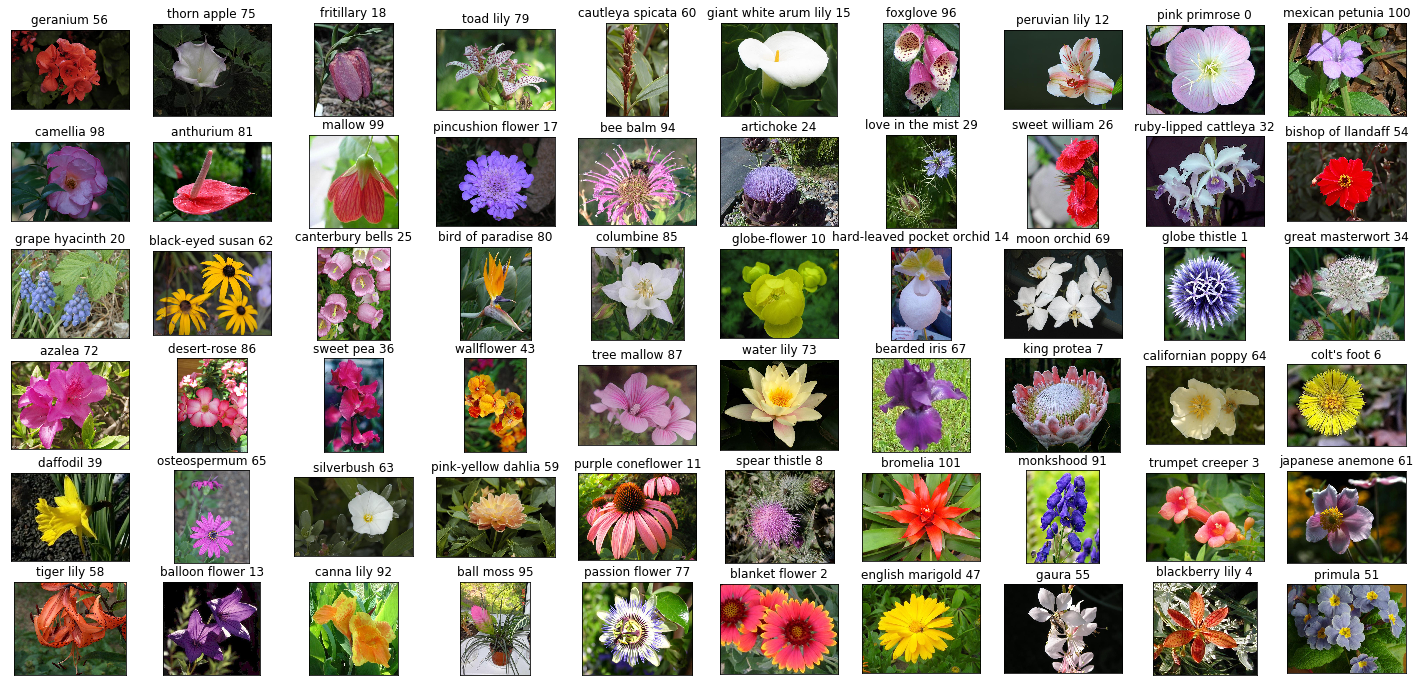

In [38]:
# Plot an original image from each training folder, and corresponding labels
# Choose 60 sub-folders at random
sub_folders = np.random.choice(len(class_to_idx), 60, replace=False)+1
images=[]
for folder in sub_folders:
    contents = os.listdir(os.path.join(train_dir,str(folder)))
    images.append(Image.open(train_dir + '/' + str(folder) + '/' + contents[0]))
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(60):
    ax = fig.add_subplot(6, 60/6, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    title = names['class'][class_to_idx[str(sub_folders[idx])]], names['labels'][class_to_idx[str(sub_folders[idx])]]
    ax.set_title(title[0] + ' ' + str(title[1]))

In [39]:
# Visualize sample data from one batch of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

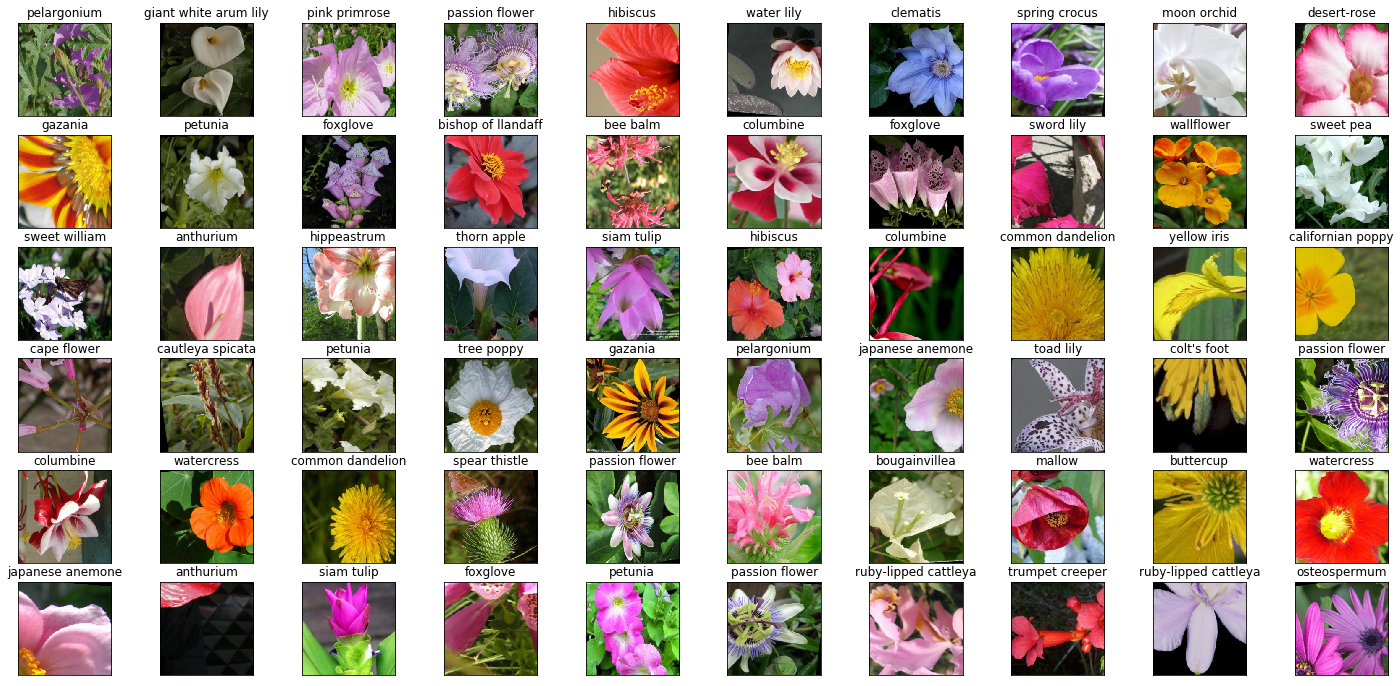

In [40]:
# Plot the images in the batch, along with the corresponding labels
# These images have been transformed
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(min(60, batch_size)):
    ax = fig.add_subplot(6, 60/6, idx+1, xticks=[], yticks=[])
    image = images[idx].numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    plt.imshow(image)
    title = names.loc[names['labels'] == labels[idx].numpy(), 'class'].iloc[0]
    ax.set_title(title)

# Building and training the classifier

A pretrained model from `torchvision.models` is used to get the image features. Using those features a new feed-forward classifier is built and trained.

Steps:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [41]:
# DenseNet201 - the pre-trained network
model = models.densenet201(pretrained=True)

# Freeze training for all "features" layers
for param in model.parameters(): param.requires_grad_(False)
    
# Definition of the classifier    
n_inputs = model.classifier.in_features
classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(n_inputs, 512)),
        ('relu', nn.ReLU()),
        ('bn1', nn.BatchNorm1d(512)),
        ('drop', nn.Dropout(0.5)),
        ('fc2', nn.Linear(512, len(train_data.classes))),
        ('softmax', nn.LogSoftmax(dim=1))
        ]))
model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=3e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

train_on_gpu = torch.cuda.is_available()
if train_on_gpu: model = model.cuda()

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


19,129,830 total parameters.
1,036,902 training parameters.


In [42]:
# TRAINING - typically gets to 97% around 15 epochs
n_epochs, valid_loss_min, trn_loss_hist, val_loss_hist, best_acc  = 20, 100, [], [], 0.0
since = time.time()
for epoch in range(1, n_epochs+1):
    train_loss, valid_loss, correct = 0.0, 0.0, 0.0 
    scheduler.step()
    model.train()
    for data, target in train_loader:
        if train_on_gpu: data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data) 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu: data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        # Get the index of the max log-probability
        _, pred = output.max(1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss, valid_loss  = train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)
    trn_loss_hist.append(train_loss)
    val_loss_hist.append(valid_loss)
    epoch_acc = correct/len(valid_data)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model, 'flowers'+str(epoch)+'.pth')
    print(f'Epoch: {epoch} Training Loss: {train_loss:.4f} Validation Loss: {valid_loss:.4f} Accuracy: {epoch_acc:.4f}')
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: 1 Training Loss: 2.4800 Validation Loss: 0.8342 Accuracy: 0.8484
Epoch: 2 Training Loss: 0.7960 Validation Loss: 0.3220 Accuracy: 0.9389
Epoch: 3 Training Loss: 0.5015 Validation Loss: 0.2481 Accuracy: 0.9474
Epoch: 4 Training Loss: 0.4032 Validation Loss: 0.2103 Accuracy: 0.9511
Epoch: 5 Training Loss: 0.3722 Validation Loss: 0.2192 Accuracy: 0.9535
Epoch: 6 Training Loss: 0.3265 Validation Loss: 0.1623 Accuracy: 0.9621
Epoch: 7 Training Loss: 0.2877 Validation Loss: 0.1571 Accuracy: 0.9645
Epoch: 8 Training Loss: 0.2707 Validation Loss: 0.1520 Accuracy: 0.9633
Epoch: 9 Training Loss: 0.2536 Validation Loss: 0.1449 Accuracy: 0.9707
Epoch: 10 Training Loss: 0.2555 Validation Loss: 0.1422 Accuracy: 0.9670
Epoch: 11 Training Loss: 0.2519 Validation Loss: 0.1388 Accuracy: 0.9670
Epoch: 12 Training Loss: 0.2564 Validation Loss: 0.1371 Accuracy: 0.9670
Epoch: 13 Training Loss: 0.2552 Validation Loss: 0.1382 Accuracy: 0.9670
Epoch: 14 Training Loss: 0.2441 Validation Loss: 0.1354 Accu

In [59]:
def plot_losses():
    ''' Plot training and validation losses
    '''
    plt.title("Training and Validation Losses")
    plt.xlabel("Training Epochs")
    plt.ylabel("Losses")
    plt.plot(range(1,len(trn_loss_hist)+1),trn_loss_hist,label="Training")
    plt.plot(range(1,len(val_loss_hist)+1),val_loss_hist,label="Validation")
    plt.ylim((0,min([1, max(trn_loss_hist)])))
    plt.xticks(np.arange(1, n_epochs+1, 1.0))
    plt.legend()
    plt.show()

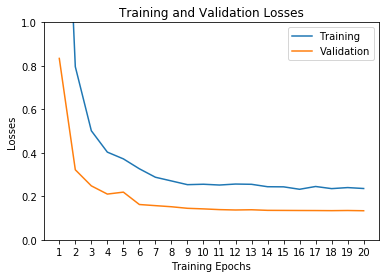

In [44]:
plot_losses()

In [46]:
model = torch.load('flowers16.pth')

In [47]:
# Unfreeze model and train further with a smaller batch size and a small learning rate
num_workers = 0
batch_size = 32 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
for param in model.parameters(): param.requires_grad_(True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

19,129,830 total parameters.
19,129,830 training parameters.


In [48]:
# Further training - typically gets to 99% in around 10 epochs
train_on_gpu = torch.cuda.is_available()
n_epochs, valid_loss_min, trn_loss_hist, val_loss_hist, best_acc  = 20, 100, [], [], 0.
since = time.time()
for epoch in range(1, n_epochs+1):
    train_loss, valid_loss, correct = 0.0, 0.0, 0.0
    scheduler.step()
    model.train()
    for data, target in train_loader:
        if train_on_gpu: data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data) 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu: data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        _, pred = output.max(1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss, valid_loss  = train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)
    trn_loss_hist.append(train_loss)
    val_loss_hist.append(valid_loss)
    epoch_acc = correct/len(valid_data)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model, 'flowers_unfr_'+str(epoch)+'.pth')
    print(f'Epoch: {epoch} Training Loss: {train_loss:.4f} Validation Loss: {valid_loss:.4f} Accuracy: {epoch_acc:.4f}')
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: 1 Training Loss: 0.2589 Validation Loss: 0.0945 Accuracy: 0.9804
Epoch: 2 Training Loss: 0.2079 Validation Loss: 0.0870 Accuracy: 0.9804
Epoch: 3 Training Loss: 0.1964 Validation Loss: 0.0832 Accuracy: 0.9780
Epoch: 4 Training Loss: 0.1652 Validation Loss: 0.0766 Accuracy: 0.9792
Epoch: 5 Training Loss: 0.1454 Validation Loss: 0.0708 Accuracy: 0.9878
Epoch: 6 Training Loss: 0.1341 Validation Loss: 0.0638 Accuracy: 0.9866
Epoch: 7 Training Loss: 0.1250 Validation Loss: 0.0747 Accuracy: 0.9817
Epoch: 8 Training Loss: 0.1334 Validation Loss: 0.0551 Accuracy: 0.9902
Epoch: 9 Training Loss: 0.1250 Validation Loss: 0.0577 Accuracy: 0.9866
Epoch: 10 Training Loss: 0.1095 Validation Loss: 0.0570 Accuracy: 0.9866
Epoch: 11 Training Loss: 0.1022 Validation Loss: 0.0528 Accuracy: 0.9890
Epoch: 12 Training Loss: 0.0965 Validation Loss: 0.0545 Accuracy: 0.9890
Epoch: 13 Training Loss: 0.0951 Validation Loss: 0.0494 Accuracy: 0.9902
Epoch: 14 Training Loss: 0.0913 Validation Loss: 0.0498 Accu

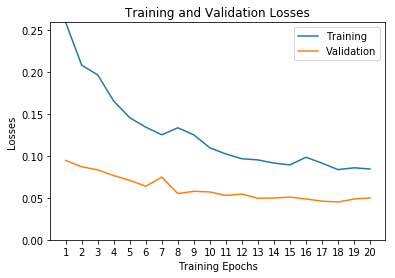

In [60]:
plot_losses()

In [9]:
#Test Accuracy on the best model
model = torch.load('flowers_unfr_18.pth') 
train_on_gpu = torch.cuda.is_available()
test_data = datasets.ImageFolder(test_dir, transform=valid_data_transforms)
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)
correct = 0
class_errors = []
for data, target in test_loader:
    if train_on_gpu: data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = output.max(1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    indices = [i for i, x in enumerate(pred.eq(target.view_as(pred))) if x == 0]
    class_errors.append(target[indices].tolist())
acc = correct/len(test_data)
print(f'Accuracy: {acc:.4f} Correctly identified: {correct} Incorrectly identified: {len(test_data)-correct}')
print (f'Classes with incorrectly identified flowers: {class_errors}')

Accuracy: 0.9915 Correctly identified: 812 Incorrectly identified: 7
Classes with incorrectly identified flowers: [[], [], [15, 17], [21], [], [], [35, 37], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [98, 98]]


In [ ]:
# Final submission - could combine train and valid data, 
# then run same training as used to get best performing (flowers_unfr_18.pth)

## Save and loading a  checkpoint

Once the network is trained, the model can be saved so that it can be loaded later for making predictions. If the model is to be used for further training, the number of epochs should be saved as well as the optimizer state, `optimizer.state_dict`.

In [20]:
# For the Challenge TEST, save a checkpoint
# Load a saved model that performed well in training
model = torch.load('flowers_unfr_18.pth') 
model.cpu()
states = {'class_to_idx': train_data.class_to_idx,
          'state_dict': model.state_dict()}
torch.save(states, 'flowers_state_dict.pth')

## Loading the checkpoint

A function is needed that can load a checkpoint and rebuild the model. 

In [21]:
# DenseNet201
import torch
from torch import nn
from torchvision import models
from collections import OrderedDict

def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
    model = models.densenet201(pretrained=False)
    for param in model.parameters(): param.requires_grad = False
    n_inputs = model.classifier.in_features
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(n_inputs, 512)),
        ('relu', nn.ReLU()),
        ('bn1', nn.BatchNorm1d(512)),
        ('drop', nn.Dropout(0.5)),
        ('fc2', nn.Linear(512, len(train_data.classes))),
        ('softmax', nn.LogSoftmax(dim=1))
        ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    model.eval()
    return model

model = load_checkpoint('flowers_state_dict.pth')

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


# Inference for classification

A function is written to use a trained network for inference. An image is passed into the network and the class of the flower in the image is predicted. 

The `predict` function takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

First the input image has to be processed  such that it can be used by the model. 

## Image Preprocessing

`PIL` is used to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). The function preprocesses the image in the same manner used for training so it can be used as input for the model.

First, the images are resized where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. 

Then a crop of the center 224x224 portion of the image is taken.

Colour channels of images are typically encoded as integers 0-255, but the model expected floats 0-1, so values are converted. This is easier with a Numpy array, so `np_image = np.array(pil_image)`.

The network expects the images to be normalized in a specific way. `[0.485, 0.456, 0.406]` for the means and `[0.229, 0.224, 0.225]` for the standard deviations . Tthe means have to be subtracted from each color channel, then the channels are divided by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Ddimensions are reordered using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The colour channel needs to be first and the order retained of the other two dimensions.

In [10]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256), Image.ANTIALIAS)
    else:
        img.thumbnail((256, 10000), Image.ANTIALIAS)
    # Centre crop
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))
    # Normalize
    img = np.array(img)/255
    img = (img - np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])
    # Change channel order
    img = img.transpose((2, 0, 1))
    return img

image = process_image(train_dir + '/54/image_05459.jpg')

As a check, if the `process_image` function works, running the output through this function displays the original image (except for the cropped out portions).

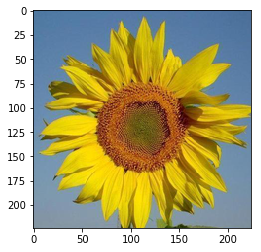

In [11]:
def imshow(image, ax=None, title=None):
    ''' Takes a processed image and undoes the processing to display the image
    '''
    if ax is None: fig, ax = plt.subplots()
    # PyTorch tensors assume the colour channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    # Undo normalizing
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = std * image + mean
    ax.imshow(image)
    return ax

imshow(image);

## Class Prediction

Once the images are in the correct format, predictions can be made with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. The class probabilities are calculated then the $K$ largest values are found.

To get the top $K$ largest values in a tensor [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk) is used. This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. `class_to_idx` converts from these indices to the actual class labels. The reverse dictionary gives a mapping from index to class.

In [12]:
def predict(image_path, model, top_num=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).type(torch.cuda.FloatTensor) #turn into a tensor
    model_input = image_tensor.unsqueeze(0) # add batch of size 1 to image
    output = model(model_input) # run image through model
    preds, classes = output.topk(top_num)
    preds = torch.exp(preds.detach()[0])
    classes = classes[0]
    cats = [idx_to_class[clas.item()] for clas in classes]
    flowers = [cat_to_name[cat] for cat in cats]
    return preds, flowers

## Sanity Checking

Plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [13]:
def plot_solution(image_path, model):
    ''' Plot side by side the top predictions for a flower
        and the image of the file
    '''
    preds, flowers = predict(image_path, model)
    text_colour = 'r'
    plt.figure(figsize = (12,6))
    ax = plt.subplot(1,2,2)
    title = cat_to_name[image_path.split('/')[-2]] + ' / predicted: ' + flowers[0]
    if cat_to_name[image_path.split('/')[-2]] == flowers[0]: text_colour = 'g'
    img = process_image(image_path)
    plt.title(title, color=text_colour)
    imshow(img, ax, title);
    plt.subplot(1,2,1)
    plt.barh(flowers, preds.detach().cpu().numpy(), align='center', color=text_colour)
    plt.xlim((0,1))
    plt.show()

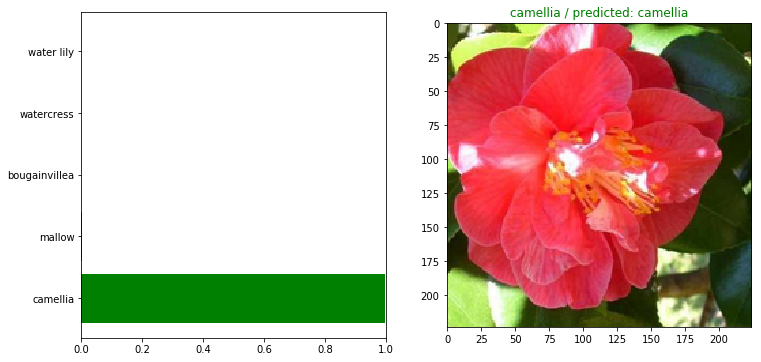

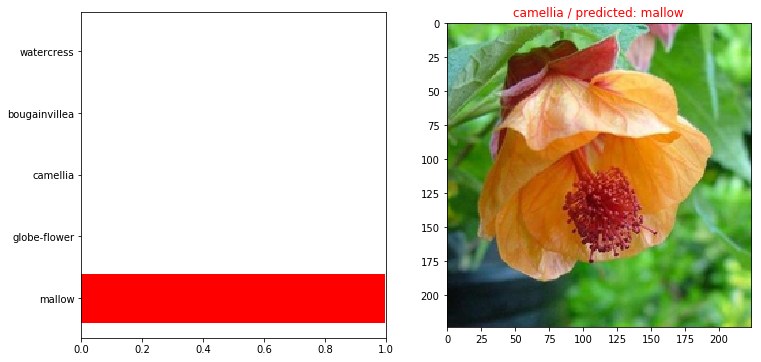

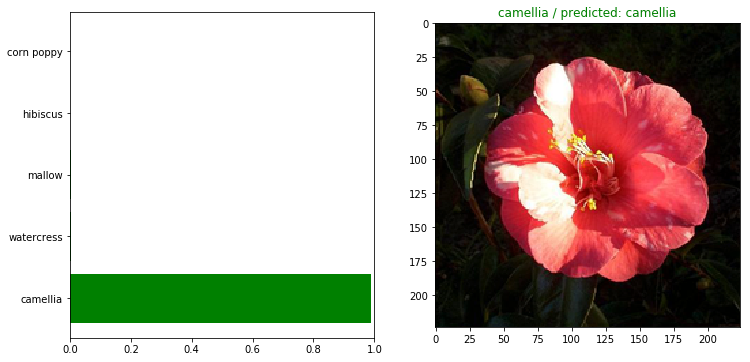

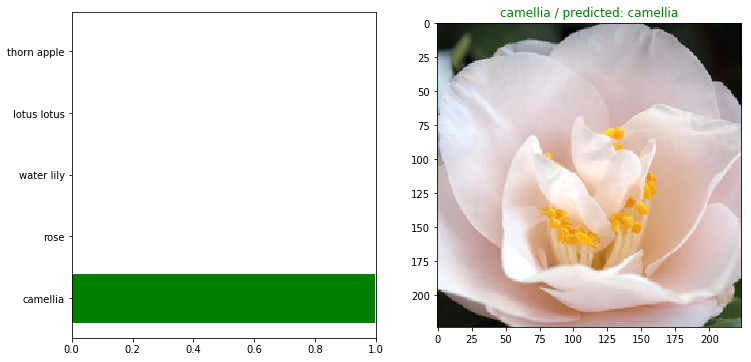

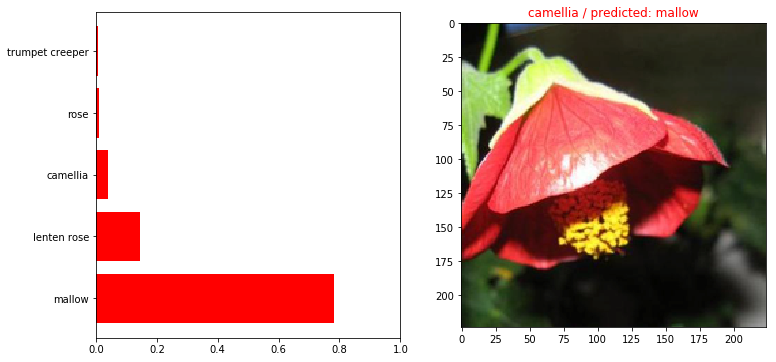

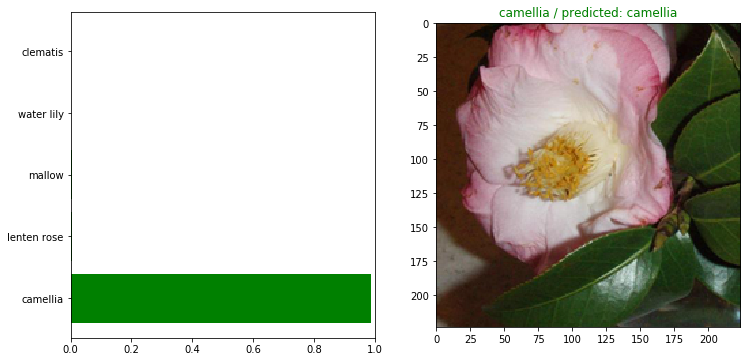

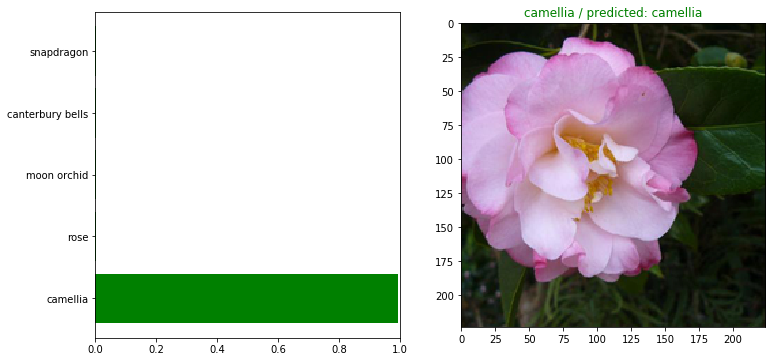

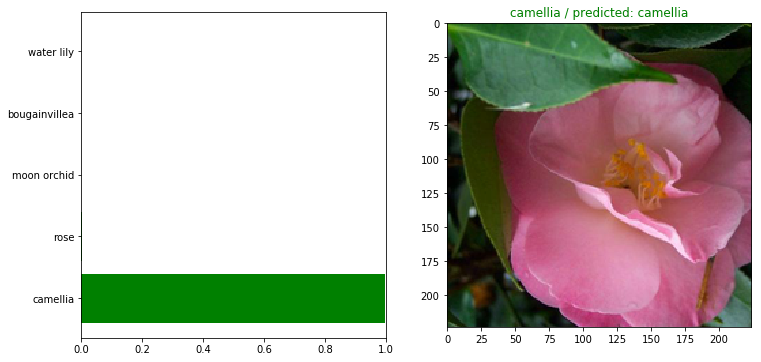

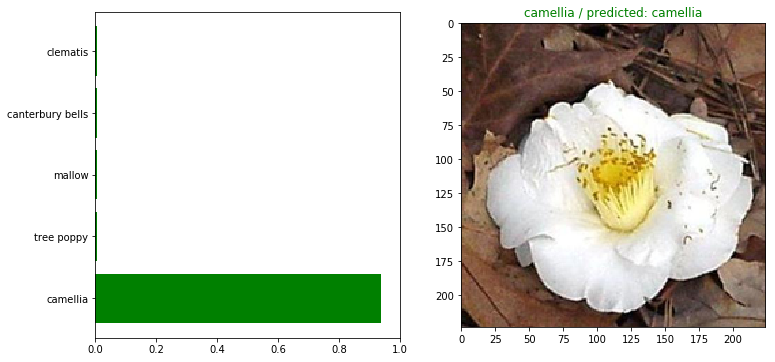

In [19]:
# Checking model predictions for individual folders in the test set where flowers were misclassified
# e.g. classes 15, 17, 21, 35, 37, 98
folder = str(idx_to_class[98])
images = os.listdir(os.path.join(test_dir,folder))
for image in images:
    image_path = test_dir + '/' + folder + '/' + image
    plot_solution(image_path, model)   